In [77]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import kerastuner as kt
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy import stats
from skimage.transform import resize
from scipy.ndimage import rotate # could use skimage rotate
import sys
import time
from pathlib import Path
from IPython import display
from astropy.io import fits 
from scipy.ndimage import rotate
import glob
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import os

In [2]:
train_images = np.load(r"Data arrays\train_images.npy")
test_images = np.load(r"Data arrays\test_images.npy")
train_labels = np.load(r"Data arrays\train_labels.npy")
test_labels = np.load(r"Data arrays\test_labels.npy")

In [3]:
print('train images: ', train_images.shape)
print('test images: ', test_images.shape)

train images:  (21355, 128, 128, 1)
test images:  (9153, 128, 128, 1)


In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [5]:
input_shape = train_images.shape[1:]

#use mish activations: 
#'relu'

#mish = tfa.activations.mish(x)

def model_builder(hp):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(hp.Int('dense', 30, 512, step=10, default=512), activation='relu'),
        layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),
        layers.Dense(1, activation='sigmoid')])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
tuner = kt.Hyperband(model_builder,objective='val_accuracy',max_epochs=30,hyperband_iterations=2,directory='my_dir',project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [9]:
batch_size = 32
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

tuner.search(train_ds.batch(batch_size),validation_data=test_ds.batch(batch_size),epochs=30,callbacks=[callback])

Trial 103 Complete [00h 03m 20s]
val_accuracy: 0.9506173133850098

Best val_accuracy So Far: 0.9583743214607239
Total elapsed time: 03h 39m 56s
INFO:tensorflow:Oracle triggered exit


In [11]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dense')}, the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the optimal dropout rate is {best_hps.get('dropout')}
.""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 460, the optimal learning rate for the optimizer
is 0.001 and the optimal dropout rate is 0.2
.


In [53]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds.batch(batch_size), validation_data=test_ds.batch(batch_size), epochs=20)

Epoch 1/20
668/668 [==============================] - 16s 23ms/step - loss: 0.1662 - accuracy: 0.9369 - val_loss: 0.2049 - val_accuracy: 0.9258
Epoch 2/20
668/668 [==============================] - 16s 24ms/step - loss: 0.0656 - accuracy: 0.9770 - val_loss: 0.2290 - val_accuracy: 0.9361
Epoch 3/20
668/668 [==============================] - 16s 24ms/step - loss: 0.0325 - accuracy: 0.9876 - val_loss: 0.3196 - val_accuracy: 0.9335
Epoch 4/20
668/668 [==============================] - 16s 24ms/step - loss: 0.0208 - accuracy: 0.9930 - val_loss: 0.3213 - val_accuracy: 0.9389
Epoch 5/20
668/668 [==============================] - 17s 26ms/step - loss: 0.0148 - accuracy: 0.9953 - val_loss: 0.2979 - val_accuracy: 0.9491
Epoch 6/20
668/668 [==============================] - 17s 26ms/step - loss: 0.0086 - accuracy: 0.9970 - val_loss: 0.5621 - val_accuracy: 0.9287
Epoch 7/20
668/668 [==============================] - 17s 26ms/step - loss: 0.0121 - accuracy: 0.9963 - val_loss: 0.4158 - val_accuracy:

Best epoch: 15


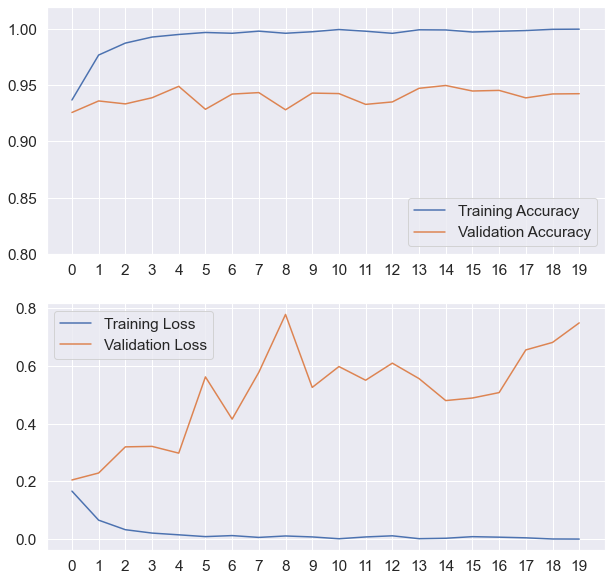

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

best_epoch = val_acc.index(max(val_acc)) + 1
print('Best epoch: %d' % (best_epoch,))

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(10, 10))
#plt.title("")
ax =plt.subplot(2, 1, 1)
plt.ylim(0.8,1.02)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xticks(ticks=range(20))
plt.legend(loc='lower right')
#plt.savefig(r'Seminar Images\10.0.png')
#plt.show()

ax2 =plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xticks(ticks=range(20))
plt.legend(loc='upper left')
#plt.title('Training and Validation Loss')
#plt.savefig(r'Seminar Images\7500_0_2500.png')
plt.show()

In [55]:
test_predictions = model.predict(test_images)
test_predictions = np.squeeze(test_predictions)

In [56]:
a = confusion_matrix(test_labels, test_predictions.round())

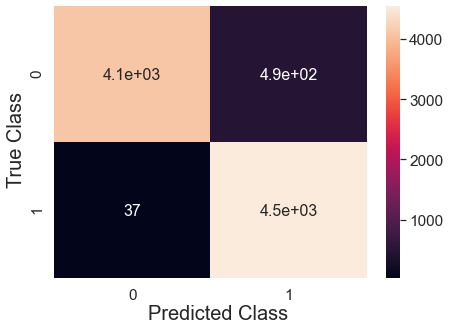

In [57]:
df_cm = pd.DataFrame(a, range(2), range(2))
plt.figure(figsize=(7,5))
#plt.title("0 : 1 : 0")
plt.text(-0.3,1.3,'True Class', fontsize=20, rotation=90)
plt.text(0.6,2.3,'Predicted Class', fontsize=20)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
#plt.savefig(r'Seminar Images\confushion_10.0.png')
plt.show()

In [59]:
model.save('saved_models/4_layer_model_tuned')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_models/4_layer_model_tuned\assets


In [ ]:
model2 = tuner.hypermodel.build(best_hps)
model2.save('saved_models/4_layer_model_tuned_untrained')